# Loading, processing, and visualizing data

This notebook shows how to load a dataset, use the preprocessor functions, and visualize the result. In this notebook we will plot the annual mean temperature from 1850 till 2100 from one model.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import iris.quickplot

from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset
from esmvalcore.esgf import download, ESGFFile
from esmvalcore.preprocessor import area_statistics, annual_statistics

Configure ESMValCore so it searches the ESGF for data

In [2]:
CFG['search_esgf'] = 'when_missing'

Define the dataset we are going to use. In this case surface air temperature (`tas`).

In [3]:
tas = Dataset(
    short_name='tas',
    mip='Amon',
    project='CMIP5',
    dataset='MPI-ESM-MR',
    ensemble='r1i1p1',
    exp='historical',
    timerange='1850/2000',
)
tas

Dataset:
{'dataset': 'MPI-ESM-MR',
 'project': 'CMIP5',
 'mip': 'Amon',
 'short_name': 'tas',
 'ensemble': 'r1i1p1',
 'exp': 'historical',
 'timerange': '1850/2000'}

In order to compute the area average later on, we add the cell areas (`areacella`) as a supplementary dataset. This will append a new dataset to the list of supplementary datasets. Its facets are copied from the `tas` dataset and updated with the provided facets:

In [4]:
tas.add_supplementary(short_name='areacella', mip='fx', ensemble='r0i0p0')
tas.supplementaries

[Dataset:
 {'dataset': 'MPI-ESM-MR',
  'project': 'CMIP5',
  'mip': 'fx',
  'short_name': 'areacella',
  'ensemble': 'r0i0p0',
  'exp': 'historical',
  'timerange': '1850/2000'}]

ESMValCore can automatically add extra facets based on the `project`, `mip`, `short_name`, and `dataset`. These extra facets are automatically added and used when searching for input files.

In [5]:
tas.augment_facets()
tas

Dataset:
{'dataset': 'MPI-ESM-MR',
 'project': 'CMIP5',
 'mip': 'Amon',
 'short_name': 'tas',
 'ensemble': 'r1i1p1',
 'exp': 'historical',
 'frequency': 'mon',
 'institute': ['MPI-M'],
 'long_name': 'Near-Surface Air Temperature',
 'modeling_realm': ['atmos'],
 'original_short_name': 'tas',
 'product': ['output1', 'output2'],
 'standard_name': 'air_temperature',
 'timerange': '1850/2000',
 'units': 'K'}
supplementaries:
  {'dataset': 'MPI-ESM-MR',
   'project': 'CMIP5',
   'mip': 'fx',
   'short_name': 'areacella',
   'ensemble': 'r0i0p0',
   'exp': 'historical',
   'frequency': 'fx',
   'institute': ['MPI-M'],
   'long_name': 'Atmosphere Grid-Cell Area',
   'modeling_realm': ['atmos', 'land'],
   'original_short_name': 'areacella',
   'product': ['output1', 'output2'],
   'standard_name': 'cell_area',
   'units': 'm2'}
session: 'session-686367c0-001c-4864-839d-c20887cf7415_20230301_160531'

Use the `find_files` method to find the files corresponding to the dataset.

In [6]:
tas.find_files()
print(tas.files)
for supplementary_ds in tas.supplementaries:
    print(supplementary_ds.files)

[ESGFFile:cmip5/output1/MPI-M/MPI-ESM-MR/historical/mon/atmos/Amon/r1i1p1/v20120503/tas_Amon_MPI-ESM-MR_historical_r1i1p1_185001-200512.nc on hosts ['aims3.llnl.gov', 'esgf.ceda.ac.uk', 'esgf.nci.org.au', 'esgf1.dkrz.de']]
[ESGFFile:cmip5/output1/MPI-M/MPI-ESM-MR/historical/fx/atmos/fx/r0i0p0/v20120503/areacella_fx_MPI-ESM-MR_historical_r0i0p0.nc on hosts ['aims3.llnl.gov', 'esgf.ceda.ac.uk', 'esgf.nci.org.au', 'esgf1.dkrz.de']]


If the files are not available locally, ESMValCore can download them for us.

In [7]:
files = list(tas.files)
for supplementary_ds in tas.supplementaries:
    files.extend(supplementary_ds.files)
files = [file for file in files if isinstance(file, ESGFFile)]
download(files, CFG['download_dir'])
tas.find_files()
print(tas.files)
for supplementary_ds in tas.supplementaries:
    print(supplementary_ds.files)

[LocalFile('~/climate_data/cmip5/output1/MPI-M/MPI-ESM-MR/historical/mon/atmos/Amon/r1i1p1/v20120503/tas_Amon_MPI-ESM-MR_historical_r1i1p1_185001-200512.nc')]
[LocalFile('~/climate_data/cmip5/output1/MPI-M/MPI-ESM-MR/historical/fx/atmos/fx/r0i0p0/v20120503/areacella_fx_MPI-ESM-MR_historical_r0i0p0.nc')]


The data in the files can be loaded into an [iris.cube.Cube](https://scitools-iris.readthedocs.io/en/latest/generated/api/iris/cube.html#iris.cube.Cube). ESMValCore will automatically check for and fix problems with the data formatting and attach the cell area.

In [8]:
cube = tas.load()
cube

<iris 'Cube' of air_temperature / (K) (time: 1812; latitude: 96; longitude: 192)>

In [9]:
cell_area = cube.cell_measures()[0]
cell_area

<CellMeasure: cell_area / (m2)  <lazy>  shape(96, 192)>

This code shows how to use some [esmvalcore.preprocessor](https://docs.esmvaltool.org/projects/esmvalcore/en/latest/api/esmvalcore.preprocessor.html) functions to compute the global annual mean temperature in degrees Celsius:

In [10]:
cube = area_statistics(cube, operator='mean')
cube = annual_statistics(cube, operator='mean')
cube.convert_units('degrees_C')

The [iris.quickplot](https://scitools-iris.readthedocs.io/en/latest/generated/api/iris/quickplot.html) module has useful functions for quickly plotting the results:

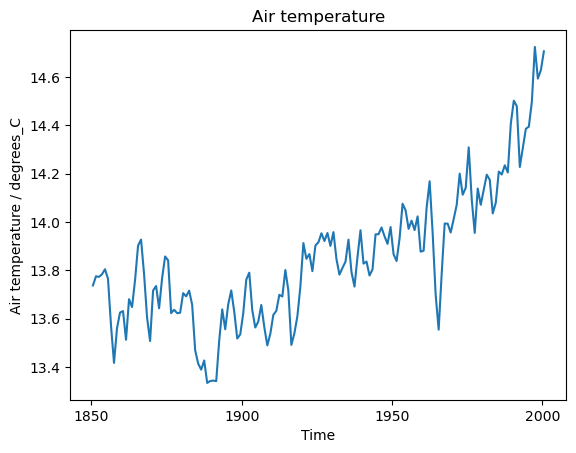

In [11]:
iris.quickplot.plot(cube)
plt.show()